In [1]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoETS, AutoTheta, AutoCES)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import yfinance as yf
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1wk')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

# Split data into training and testing sets
Y_train_df = Y_df[Y_df.ds <= '2023-1-01'] # Train set
Y_test_df = Y_df[Y_df.ds > '2023-01-01']   # Test set

[*********************100%%**********************]  8 of 8 completed


In [3]:
season_length = 52 # Define season length as 12 months for monthly data

# Define a list of models for forecasting
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='W',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(df=Y_df)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [4]:
# Generate forecasts for the specified horizon
horizon = 12

# Generate the forecast
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon)

In [5]:
# Reset the index of Y_hat_df to make unique_id a column
Y_hat_df_reset = Y_hat_df.reset_index()

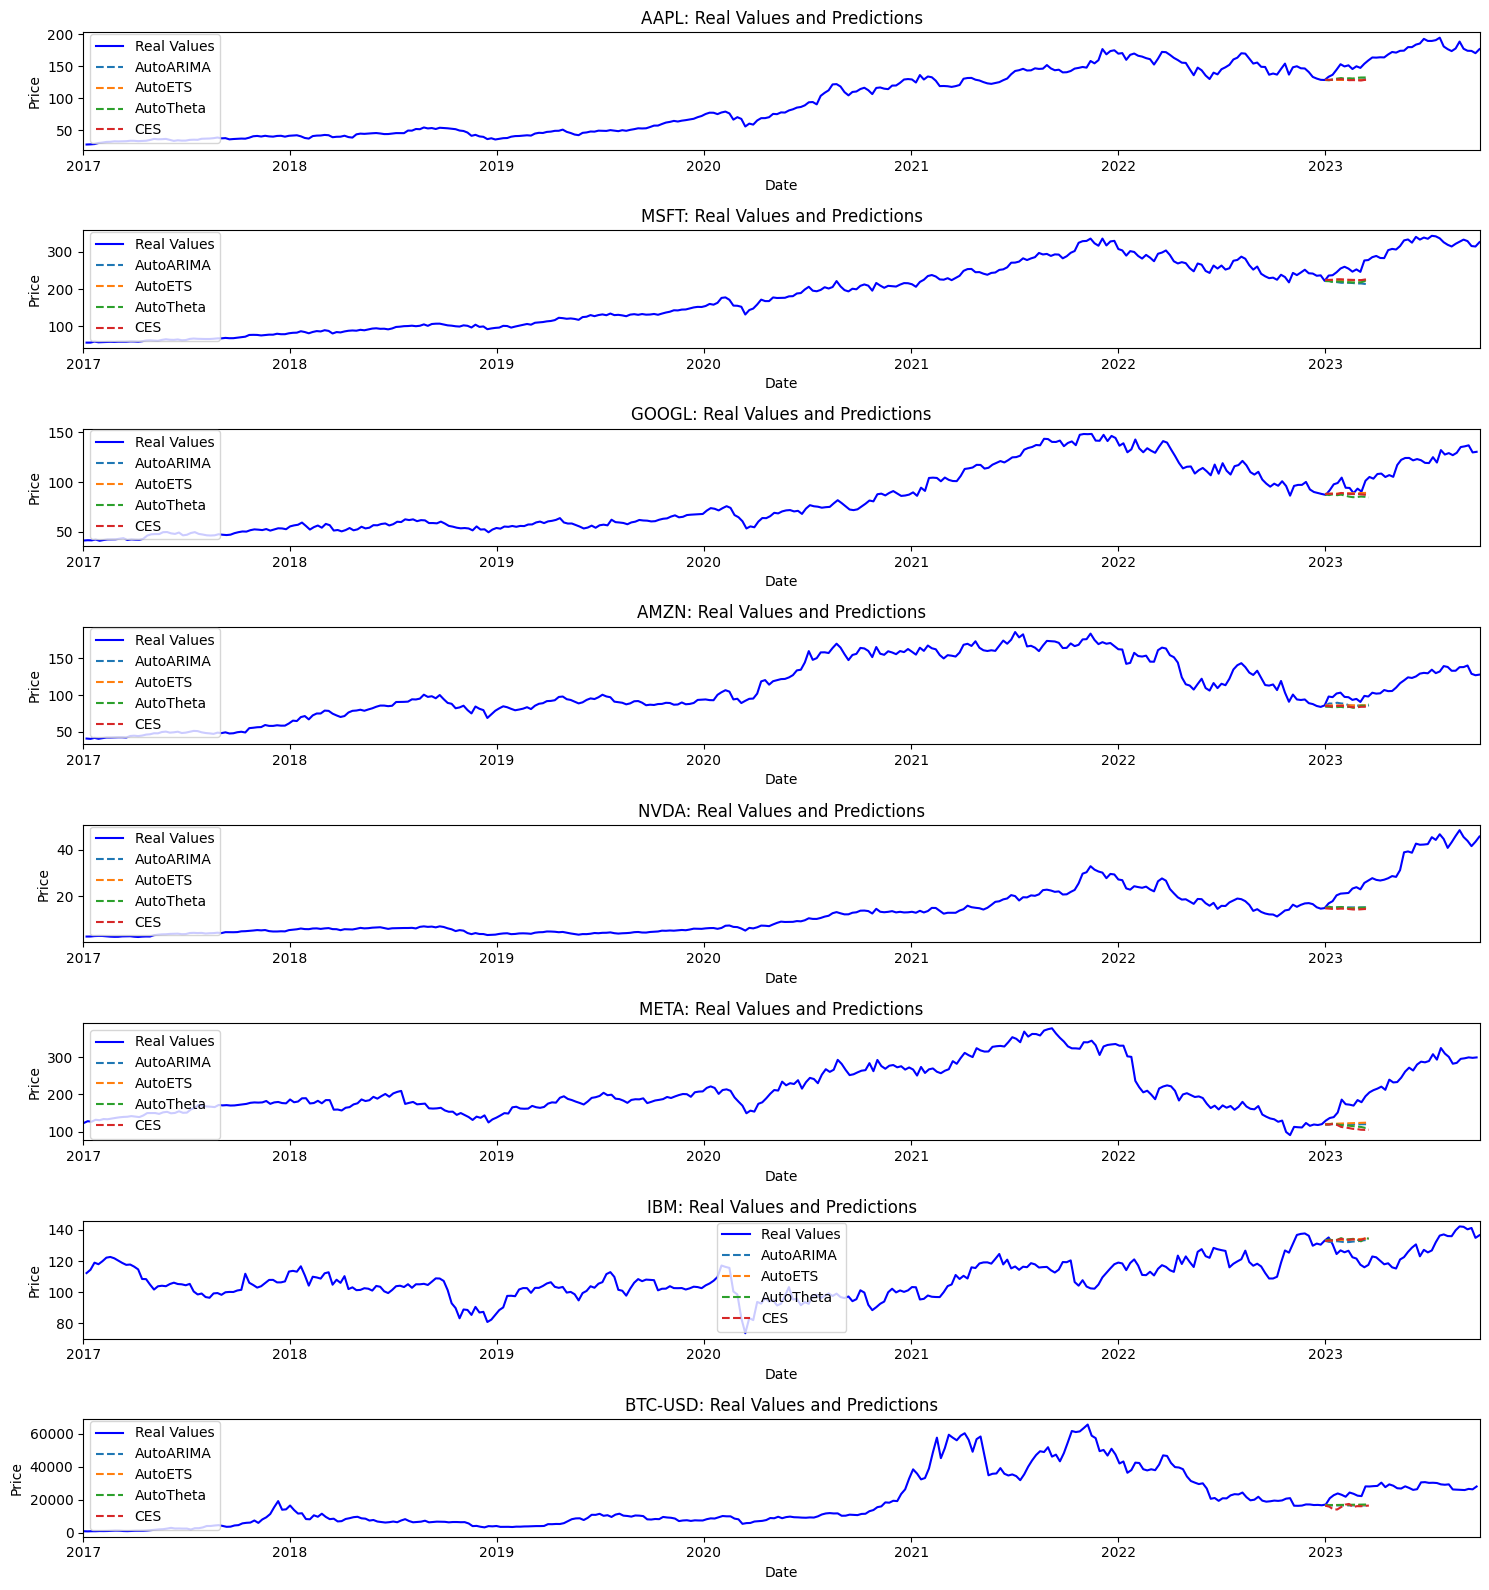

In [6]:
fig, axs = plt.subplots(len(tickers), figsize=(15, 2 * len(tickers)))

# Define the date range for focusing on the forecast area
forecast_start_date = pd.to_datetime('2023-01-01')
forecast_end_date = pd.to_datetime('2023-10-01')

# Set historical start date to January 1, 2017
historical_start_date = pd.to_datetime('2017-01-01')

# Iterate through each ticker and plot in a separate subplot
for i, ticker in enumerate(tickers):
    # Filter training, test, and prediction data for that ticker
    train_data = Y_train_df[Y_train_df['unique_id'] == ticker]
    test_data = Y_test_df[Y_test_df['unique_id'] == ticker]
    pred_data = Y_hat_df_reset[Y_hat_df_reset['unique_id'] == ticker]
    
    # Combine real data starting from the historical date
    real_data = pd.concat([
        train_data[train_data['ds'] >= historical_start_date],
        test_data[(test_data['ds'] >= forecast_start_date) & (test_data['ds'] <= forecast_end_date)]
    ])

    # Filter predictions for the relevant date range
    pred_data_filtered = pred_data[(pred_data['ds'] >= forecast_start_date) & (pred_data['ds'] <= forecast_end_date)]

    # Plot real values
    axs[i].plot(real_data['ds'], real_data['y'], label='Real Values', color='blue')

    # Plot predictions for each model
    for model in ['AutoARIMA', 'AutoETS', 'AutoTheta', 'CES']:
        if model in pred_data_filtered.columns:
            axs[i].plot(pred_data_filtered['ds'], pred_data_filtered[model], label=model, linestyle='--')

    # Set title and labels
    axs[i].set_title(f'{ticker}: Real Values and Predictions')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Price')
    axs[i].legend()

    # Set x-axis limits to focus on the relevant period
    axs[i].set_xlim(historical_start_date, forecast_end_date)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()